# Exploration_11

## 1. Chat Bot

### 1.1 Module

- 사용할 모듈을 불러옵니다.

In [4]:
import os
import re
import cv2
import numpy as np
import pandas as pd
import missingno as msno
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from google.colab import drive
from google.colab.patches import cv2_imshow

### 1.2 Function

#### 1.2.1 Tokenize

- tokenize와 max_len으로 길이를 맞추기 위해 만들지만, 문장을 자르지 않을 겁니다.  
모든 문장은 소중하니까요.

In [ ]:
def tokenize(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        if len(sentence1) <= max_len and len(sentence2) <= max_len:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)        

    return tokenized_inputs, tokenized_outputs

### 1.3 Data

#### 1.3.1 Data Load

- 구글 드라이브를 마운트합니다.

In [6]:
drive.mount('/gdrive')

Mounted at /gdrive


- 사용할 데이터를 불러옵니다.
- 한국어 챗봇 데이터는 https://github.com/songys/Chatbot_data 송영숙님 데이터를 사용합니다. 

In [ ]:
data = pd.read_csv('/gdrive/My Drive/Colab Notebooks/data/chat_bot/ChatbotData.csv')

In [ ]:
data.tail(5)

,Q,A,label
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2
11822,힘들어서 결혼할까봐,도피성 결혼은 하지 않길 바라요.,2


#### 1.3.2 Data Preprocessing

##### 1) Null

- missingno를 통해 테이터의 null 값을 확인합니다.

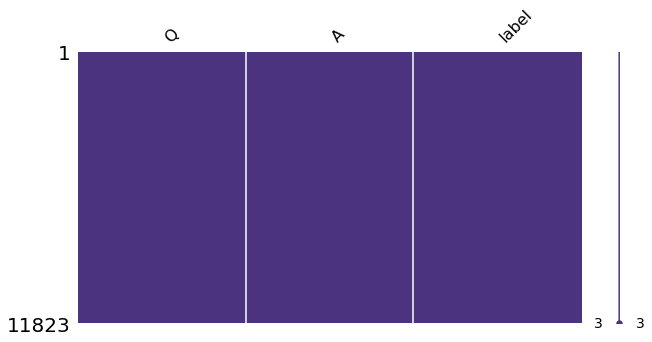

In [ ]:
msno.matrix(df=data.iloc[:, :], color=(0.3, 0.2, 0.5), figsize=(10,5))

- missingno matrix의 sparkline에서의 결측치를 확인합니다.
- 없습니다.

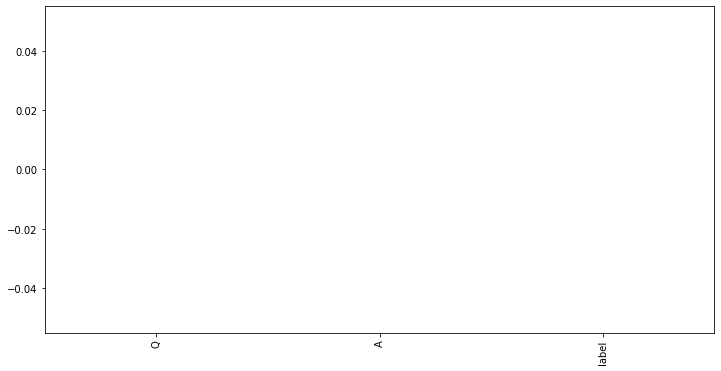

In [ ]:
missing = data.isnull().sum()
missing = missing[missing >= 0]
missing.sort_values(inplace=True)
missing.plot.bar(figsize = (12,6))

- 허전하네요 점이라도 하나 찍어주고 싶습니다.

In [ ]:
# data = data.dropna()

- drop할 null 값이 없으므로 생략합니다.

##### 2) Duplicates

- nunique를 이용해 중복데이터도 확인합니다.

In [ ]:
print('data | Q : ', len(data['Q']))
print('data | A : ', len(data['A']))

data | Q :  11823
data | A :  11823


In [ ]:
print('data | Q : ', data['Q'].nunique())
print('data | A : ', data['A'].nunique())

data | Q :  11662
data | A :  7779


- Q에서 161개, A에서 4,044개의 중복이 있습니다.

In [ ]:
Q_duplicated = data[data['Q'].duplicated()]
print(Q_duplicated.tail(5))

                           Q                A  label
11642    착해서 잘해주는 건지 좋아하는 건지     헷갈린다고 말해보세요.      2
11649         첫 눈에 반하는게 가능해?        당연히 가능하죠.      2
11658                첫사랑 생각나   지금의 사랑에 충실하세요.      2
11732  커플여행이 나을까 그냥 우리끼리 갈까?  저는 둘이 가는 게 좋아요.      2
11819         훔쳐보는 것도 눈치 보임.    훔쳐보는 거 티나나봐요.      2


- A 답변이 중복일 수는 있습니다. 예를들면...

1) 너 가장 좋아하는 채소가 뭐야?   - 당근이요   
2) 중고거래하는 어플 00마켓이던데 00이 뭐였더라? - 당근이요

- 반대로 같은 질문에 대답이 다른 경우가 섞여있을 수 있다고 판단해서,  
A 컬럼의 중복은 살려두고, Q의 중복만 제거하려합니다.

In [ ]:
data.drop_duplicates(subset=['Q'], keep='first', inplace=True)

In [ ]:
print('data | Q : ', len(data['Q']))
print('data | A : ', len(data['A']))

data | Q :  11662
data | A :  11662


- 정규 표현식을 사용하여 전처리를 해줍니다.  
  컬럼이 2개뿐이므로 직접 해줍니다.

In [ ]:
questions = []
for sentence in data['Q']:
    sentence = re.sub(r'([?.!,])', r' \1 ', sentence)
    sentence = sentence.strip()
    questions.append(sentence)

print(questions[:3])

['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다']


In [ ]:
answers = []
for sentence in data['A']:
    sentence = re.sub(r'([?.!,])', r' \1 ', sentence)
    sentence = sentence.strip()
    answers.append(sentence)

print(answers[:3])

['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .']


- 잘 분리되었습니다.

#### 1.3.3 Tokenize

##### 1) Vocab

- subword text encoder를 이용해서 단어장을 만듭니다.

In [ ]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

- 디코더 입력에 필요한 start와 end 토큰은 각각 단어장 크기와 단어장 크기 +1개로 지정해 단어장과 겹치지 않게 합니다.

In [ ]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [ ]:
print('START_TOKEN의 번호:', [tokenizer.vocab_size])
print('END_TOKEN의 번호:', [tokenizer.vocab_size + 1])

START_TOKEN의 번호: [8112]
END_TOKEN의 번호: [8113]


- start, end를 추가했으니 단어장 크기에 +2를 해줍니다.

In [ ]:
VOCAB_SIZE = tokenizer.vocab_size + 2  # STRAT, END TOKEN 추가 
print(VOCAB_SIZE)

8114


- 단어장이 잘 만들어졌습니다.

- 인코딩전에 max_len을 잡아줍니다.   
항상 느끼지만 문장이 너무 길지 않으면 자르지 않는게 최선이라고 생각합니다.

##### 2) Max_len

Text(0.5, 1.0, 'answer length')

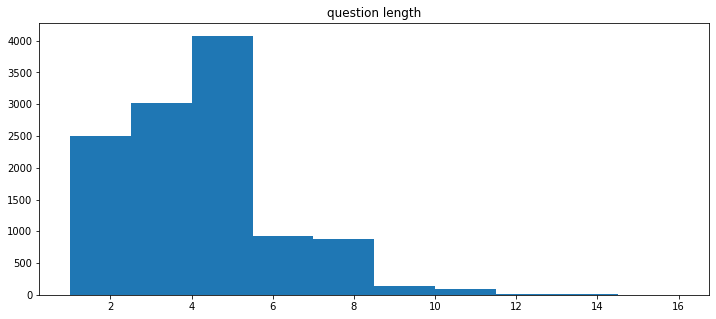

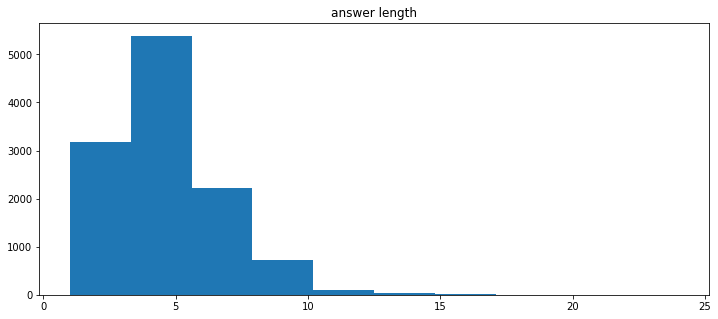

In [ ]:
question_len = [len(s.split()) for s in questions]
answer_len = [len(s.split()) for s in answers]

plt.figure(figsize=(12, 5))
plt.hist(question_len)
plt.title('question length')

plt.figure(figsize=(12, 5))
plt.hist(answer_len)
plt.title('answer length')

In [ ]:
print(max(question_len))
print(max(answer_len))

16
24


- 가장 긴 문장에 start, end 토큰을 붙이고 디코더의 input 값에서 end 토큰이 잘리는 것을 막기 위해 max_len은 27로 설정하겠습니다.

##### 3) Tokenize

In [ ]:
max_len = 27
print(max_len)

27


- tokenizer를 이용합니다.  
questions와 answers에 앞뒤로 start, end 토큰도 붙입니다.  
padding도 같이 진행합니다.

In [ ]:
questions, answers = tokenize(questions, answers)

In [ ]:
print(questions[50])
print(answers[50])

[8112, 3145, 305, 8091, 8014, 8029, 11, 667, 8113]
[8112, 499, 123, 1, 8113]


##### 4) Padding

- padding을 해줍니다.

In [ ]:
questions = tf.keras.preprocessing.sequence.pad_sequences(questions, maxlen=max_len, padding='post')
answers = tf.keras.preprocessing.sequence.pad_sequences(answers, maxlen=max_len, padding='post')

In [ ]:
print(questions[50])
print(answers[50])

[8112 3145  305 8091 8014 8029   11  667 8113    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]
[8112  499  123    1 8113    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]


- 잘 붙은 것을 확인할 수 있습니다.

##### 5) Dataset

- 데이터셋을 만들어줍니다.

In [ ]:
BATCH_SIZE = 128
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': answers[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

### 1.4 Transformer

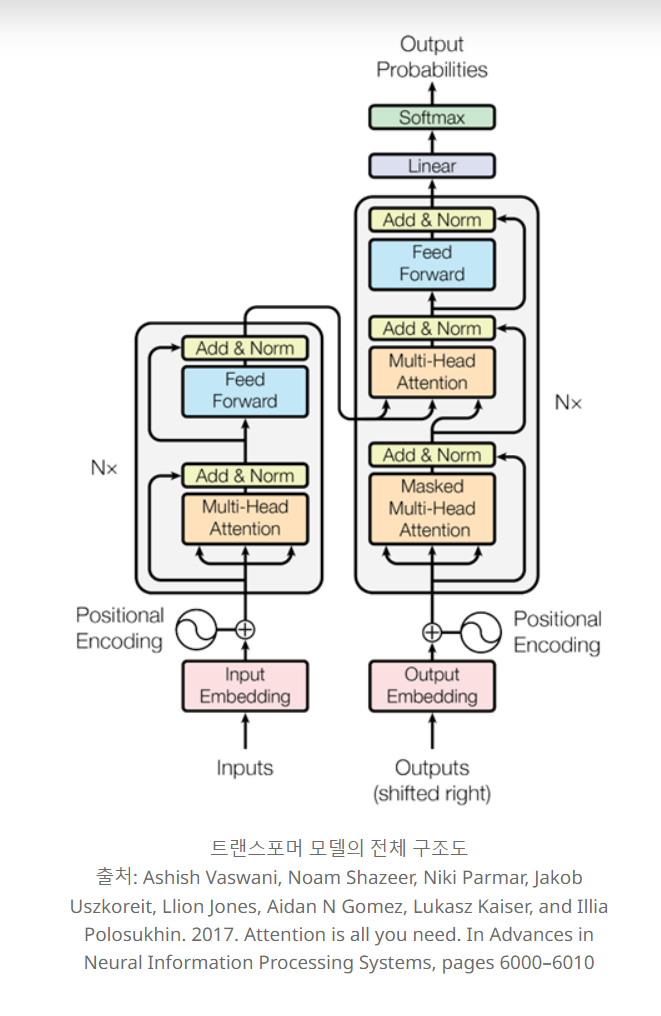

In [9]:
insert_img_9 = '/gdrive/My Drive/Colab Notebooks/data/chat_bot/images/transformer_1.png'
insert_img_9 = cv2.imread(insert_img_9)
cv2_imshow(insert_img_9)

- 만들어볼 transformer의 전체적인 구조입니다.

#### 1.4.1 Positional Encoding

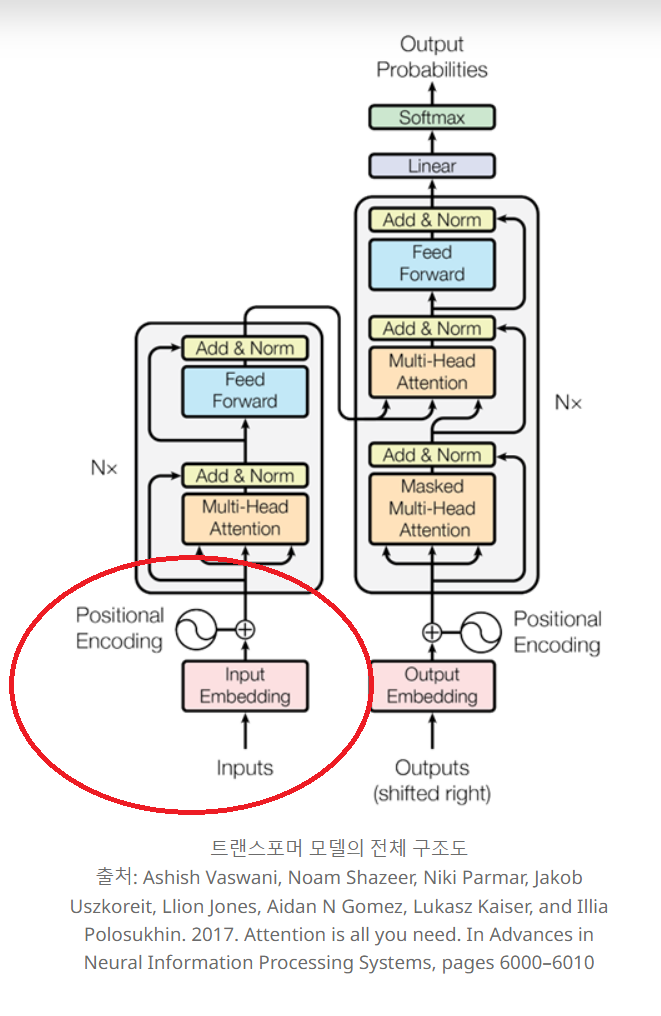

In [12]:
insert_img_10 = '/gdrive/My Drive/Colab Notebooks/data/chat_bot/images/transformer_2.png'
insert_img_10 = cv2.imread(insert_img_10)
cv2_imshow(insert_img_10)

- 인풋에 위치 벡터값을 주기 위한 Positional Encoding을 만들어줍니다.

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 짝수, 홀수 index
    sines = tf.math.sin(angle_rads[:, 0::2])
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

#### 1.4.2 Encoder

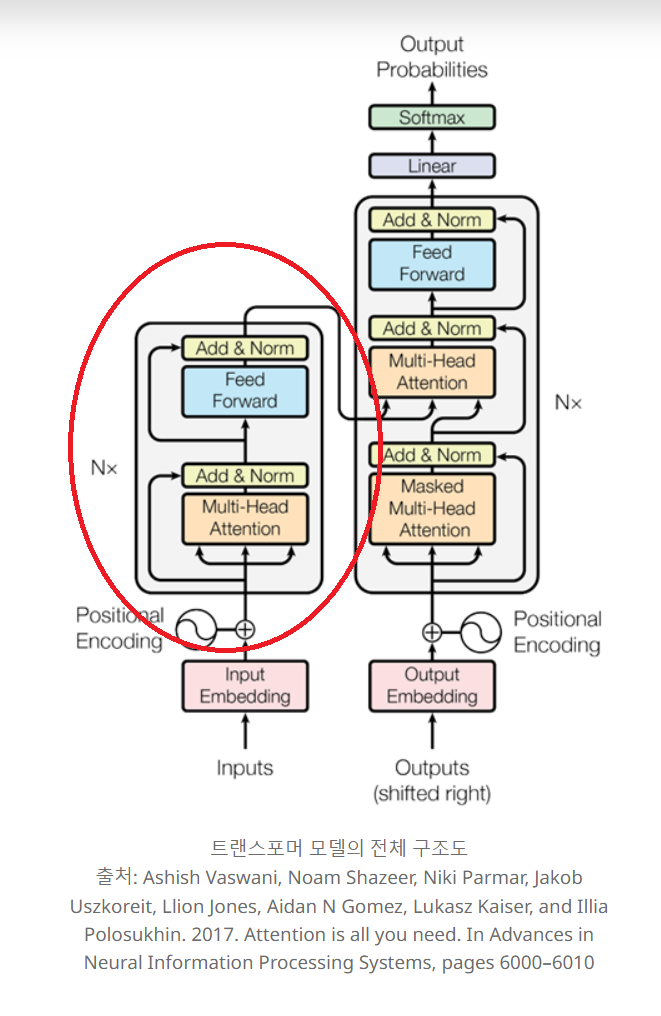

In [13]:
insert_img_11 = '/gdrive/My Drive/Colab Notebooks/data/chat_bot/images/transformer_3.png'
insert_img_11 = cv2.imread(insert_img_11)
cv2_imshow(insert_img_11)

- encoder 부분입니다.

##### 1) Scaled Dot Product Attention

- 스케일 닷 어텐션으로 유사도를 구해줍니다.

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

##### 2) Multi Head Attention

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

##### 3) Look Ahead Mask

- 마스킹을 통해 의미 없는 padding을 제외합니다.  
tf.cast를 통해 숫자가 0인 부분을 체크해서 리턴합니다.

In [ ]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

- 수행할 작업은 이전 단어로 다음 단어를 예측하는 과정이므로 자신보다 다음에 나올 단어를 가려줘야합니다.

In [ ]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

##### 4) Encoder Layer

In [ ]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

##### 5) Encoder

In [ ]:
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

#### 1.4.3 Decoder

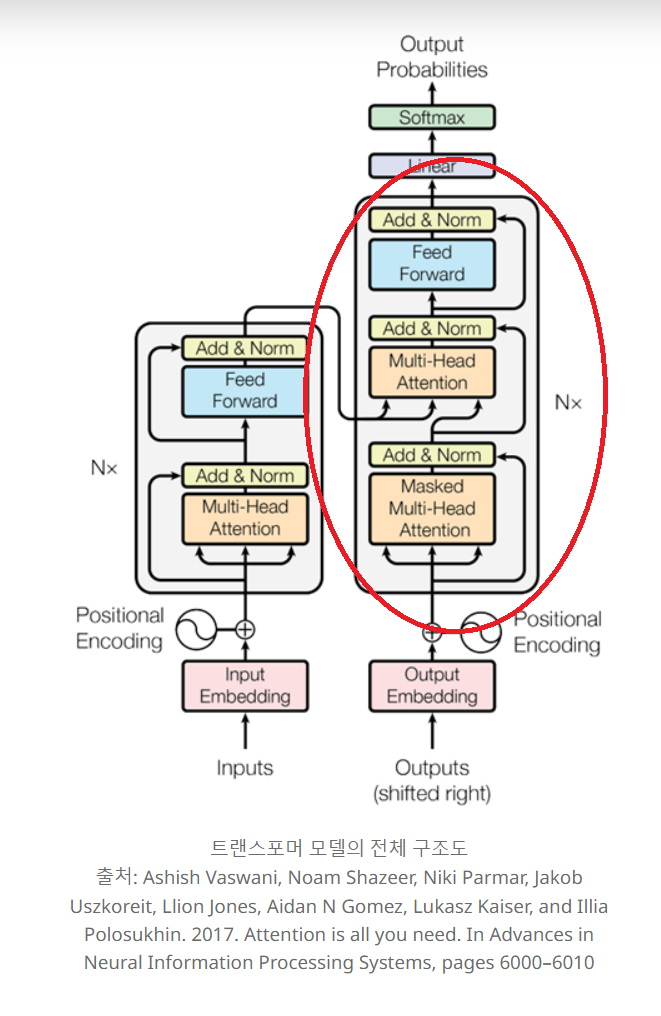

In [14]:
insert_img_12 = '/gdrive/My Drive/Colab Notebooks/data/chat_bot/images/transformer_4.png'
insert_img_12 = cv2.imread(insert_img_12)
cv2_imshow(insert_img_12)

- decoder 부분입니다.

##### 1) Decoder Layer

In [ ]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

##### 2) Decoder

In [ ]:
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

#### 1.4.4 Transformer Model

- 트랜스포머 모델

In [ ]:
def transformer(vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, 
      output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, 
      output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

### 1.5 Model

##### 1) Model Create

- transformer를 바탕으로 model을 생성합니다.

In [ ]:
# 하이퍼파라미터
NUM_LAYERS = 2      # 인코더와 디코더의 층의 개수
D_MODEL = 256       # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8       # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512         # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.2       # 드롭아웃의 비율

- hyper parameter는 모델의 생성 단계에서 들어갑니다.

In [ ]:
tf.keras.backend.clear_session()

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3131392     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

- summary를 찍어 모델이 잘 생성되었는지 확인할 수 있습니다.

##### 2) Loss Function

- Loss Function을 정의합니다.

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, max_len - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

3) Learning Rate

- Learning Rate Schedule을 사용해 learning rate를 처음에 크게 주고 step에 따라 줄어들게 설정할 수 있습니다.
- https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/LearningRateSchedule

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

- d_model값에 따른 변화를 plt으로 확인할 수 있습니다.

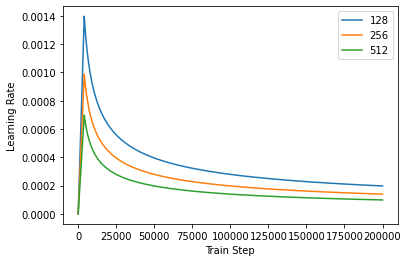

In [ ]:
sample_learning_rate_1 = CustomSchedule(d_model=128)
sample_learning_rate_2 = CustomSchedule(d_model=256)
sample_learning_rate_3 = CustomSchedule(d_model=512)

plt.plot(sample_learning_rate_1(tf.range(200000, dtype=tf.float32)))
plt.plot(sample_learning_rate_2(tf.range(200000, dtype=tf.float32)))
plt.plot(sample_learning_rate_3(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.legend(['128', '256', '512'], loc='upper right')
plt.show()

##### 3) Model Compile

- 가장 기본이 될 default model 을 compile 합니다.

In [ ]:
model0_1 = model

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, max_len - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model0_1.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

##### 4) Model Fit

- 모든 모델은 epochs 20으로 학습합니다.

In [ ]:
EPOCHS = 20
history0_1 = model0_1.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
92/92 [==============================] - 16s 66ms/step - loss: 2.3028 - accuracy: 0.0198
Epoch 2/20
92/92 [==============================] - 6s 65ms/step - loss: 2.0949 - accuracy: 0.0439
Epoch 3/20
92/92 [==============================] - 6s 66ms/step - loss: 1.8756 - accuracy: 0.0732
Epoch 4/20
92/92 [==============================] - 6s 66ms/step - loss: 1.6733 - accuracy: 0.0745
Epoch 5/20
92/92 [==============================] - 6s 65ms/step - loss: 1.5433 - accuracy: 0.0752
Epoch 6/20
92/92 [==============================] - 6s 65ms/step - loss: 1.4605 - accuracy: 0.0775
Epoch 7/20
92/92 [==============================] - 6s 65ms/step - loss: 1.4067 - accuracy: 0.0806
Epoch 8/20
92/92 [==============================] - 6s 65ms/step - loss: 1.3582 - accuracy: 0.0834
Epoch 9/20
92/92 [==============================] - 6s 64ms/step - loss: 1.3124 - accuracy: 0.0856
Epoch 10/20
92/92 [==============================] - 6s 64ms/step - loss: 1.2650 - accuracy: 0.0887
Epoch 11

- 비교할 게 없으니 잘 나온 건지 모르겠습니다.

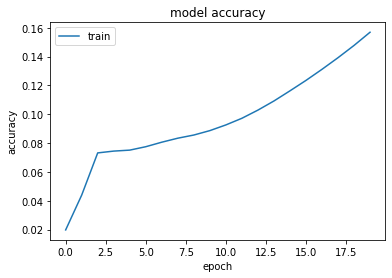

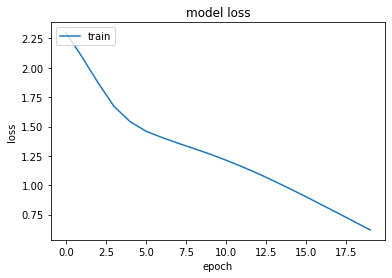

In [ ]:
plt.plot(history0_1.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

plt.plot(history0_1.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

- 더 학습하면 accuracy와 loss값이 개선될 것이라고 판단하지만, 비교를 위해 다음으로 넘어갑니다.

### 1.6 Hyper Parameter

- hyper parameter를 수정하며 변화를 살펴봅니다.

#### 1.6.1 Learning_Rate

- learning_rate 값을 0.001, 0.0001로 고정한 값을 비교해봅니다.

##### 1) High

In [ ]:
model1_1 = model

In [ ]:
# 하이퍼파라미터
NUM_LAYERS = 2      # 인코더와 디코더의 층의 개수
D_MODEL = 256       # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8       # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512         # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.2       # 드롭아웃의 비율

In [ ]:
learning_rate = 0.001 # 0.001로 고정

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, max_len - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model1_1.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 20
history1_1 = model1_1.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
92/92 [==============================] - 12s 64ms/step - loss: 1.6152 - accuracy: 0.0684
Epoch 2/20
92/92 [==============================] - 6s 64ms/step - loss: 1.3783 - accuracy: 0.0815
Epoch 3/20
92/92 [==============================] - 6s 65ms/step - loss: 1.2534 - accuracy: 0.0898
Epoch 4/20
92/92 [==============================] - 6s 64ms/step - loss: 1.0925 - accuracy: 0.1028
Epoch 5/20
92/92 [==============================] - 6s 64ms/step - loss: 0.9341 - accuracy: 0.1196
Epoch 6/20
92/92 [==============================] - 6s 64ms/step - loss: 0.7894 - accuracy: 0.1356
Epoch 7/20
92/92 [==============================] - 6s 64ms/step - loss: 0.6648 - accuracy: 0.1503
Epoch 8/20
92/92 [==============================] - 6s 64ms/step - loss: 0.5538 - accuracy: 0.1646
Epoch 9/20
92/92 [==============================] - 6s 64ms/step - loss: 0.4600 - accuracy: 0.1772
Epoch 10/20
92/92 [==============================] - 6s 64ms/step - loss: 0.3788 - accuracy: 0.1888
Epoch 11

##### 2) Low

In [ ]:
model1_2 = model

In [ ]:
# 하이퍼파라미터
NUM_LAYERS = 2      # 인코더와 디코더의 층의 개수
D_MODEL = 256       # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8       # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512         # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.2       # 드롭아웃의 비율

In [ ]:
learning_rate = 0.0001 # 0.0001로 고정

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, max_len - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model1_2.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 20
history1_2 = model1_2.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
92/92 [==============================] - 12s 69ms/step - loss: 2.0158 - accuracy: 0.0506
Epoch 2/20
92/92 [==============================] - 7s 72ms/step - loss: 1.6698 - accuracy: 0.0745
Epoch 3/20
92/92 [==============================] - 6s 69ms/step - loss: 1.5389 - accuracy: 0.0752
Epoch 4/20
92/92 [==============================] - 6s 69ms/step - loss: 1.4640 - accuracy: 0.0777
Epoch 5/20
92/92 [==============================] - 6s 67ms/step - loss: 1.4178 - accuracy: 0.0805
Epoch 6/20
92/92 [==============================] - 6s 64ms/step - loss: 1.3817 - accuracy: 0.0828
Epoch 7/20
92/92 [==============================] - 6s 66ms/step - loss: 1.3503 - accuracy: 0.0841
Epoch 8/20
92/92 [==============================] - 6s 68ms/step - loss: 1.3201 - accuracy: 0.0857
Epoch 9/20
92/92 [==============================] - 6s 68ms/step - loss: 1.2934 - accuracy: 0.0873
Epoch 10/20
92/92 [==============================] - 6s 70ms/step - loss: 1.2672 - accuracy: 0.0887
Epoch 11

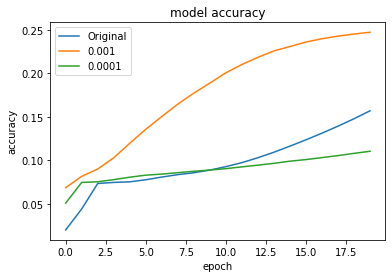

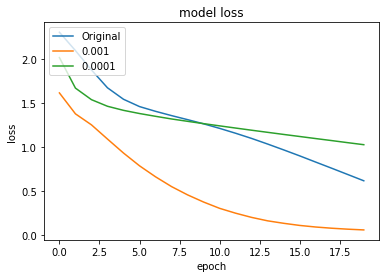

In [ ]:
plt.plot(history0_1.history['accuracy'])
plt.plot(history1_1.history['accuracy'])
plt.plot(history1_2.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Original', '0.001', '0.0001'], loc='upper left')
plt.show()

plt.plot(history0_1.history['loss'])
plt.plot(history1_1.history['loss'])
plt.plot(history1_2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Original', '0.001', '0.0001'], loc='upper left')
plt.show()

- Original은 Learning Rate Schedule입니다.  
  Learning Rate Schedule을 사용하기 보다는 0.001 값을 지정하여 사용하는게 더 효율적이었나 봅니다.

#### 1.6.2 Optimizer

- 최애 Optimizer를 바꿔가며 확인해봅니다.  
주로 사용하는 Nadam, RSMprop을 써봅니다.

##### 1) Nadam

In [ ]:
model2_1 = model

In [ ]:
# 하이퍼파라미터
NUM_LAYERS = 2      # 인코더와 디코더의 층의 개수
D_MODEL = 256       # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8       # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512         # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.2       # 드롭아웃의 비율

In [ ]:
learning_rate = 0.001

optimizer = tf.keras.optimizers.Nadam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, max_len - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model2_1.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 20
history2_1 = model2_1.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
92/92 [==============================] - 17s 70ms/step - loss: 1.6472 - accuracy: 0.0706
Epoch 2/20
92/92 [==============================] - 7s 72ms/step - loss: 1.4212 - accuracy: 0.0783
Epoch 3/20
92/92 [==============================] - 7s 72ms/step - loss: 1.3357 - accuracy: 0.0838
Epoch 4/20
92/92 [==============================] - 6s 69ms/step - loss: 1.2448 - accuracy: 0.0891
Epoch 5/20
92/92 [==============================] - 6s 69ms/step - loss: 1.1153 - accuracy: 0.0988
Epoch 6/20
92/92 [==============================] - 6s 70ms/step - loss: 0.9712 - accuracy: 0.1116
Epoch 7/20
92/92 [==============================] - 7s 74ms/step - loss: 0.8344 - accuracy: 0.1268
Epoch 8/20
92/92 [==============================] - 7s 71ms/step - loss: 0.7075 - accuracy: 0.1413
Epoch 9/20
92/92 [==============================] - 6s 69ms/step - loss: 0.5951 - accuracy: 0.1553
Epoch 10/20
92/92 [==============================] - 6s 69ms/step - loss: 0.4985 - accuracy: 0.1680
Epoch 11

##### 2) RMSprop

In [ ]:
model2_2 = model

In [ ]:
# 하이퍼파라미터
NUM_LAYERS = 2      # 인코더와 디코더의 층의 개수
D_MODEL = 256       # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8       # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512         # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.2       # 드롭아웃의 비율

In [ ]:
learning_rate = 0.001

optimizer = tf.keras.optimizers.RMSprop(learning_rate, rho=0.9, momentum=0.0, epsilon=1e-9, centered=True)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, max_len - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model2_2.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 20
history2_2 = model2_2.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
92/92 [==============================] - 15s 68ms/step - loss: 1.6378 - accuracy: 0.0654
Epoch 2/20
92/92 [==============================] - 6s 67ms/step - loss: 1.4536 - accuracy: 0.0767
Epoch 3/20
92/92 [==============================] - 7s 73ms/step - loss: 1.3879 - accuracy: 0.0805
Epoch 4/20
92/92 [==============================] - 6s 69ms/step - loss: 1.3455 - accuracy: 0.0832
Epoch 5/20
92/92 [==============================] - 6s 70ms/step - loss: 1.3004 - accuracy: 0.0859
Epoch 6/20
92/92 [==============================] - 7s 71ms/step - loss: 1.2575 - accuracy: 0.0883
Epoch 7/20
92/92 [==============================] - 6s 69ms/step - loss: 1.2171 - accuracy: 0.0906
Epoch 8/20
92/92 [==============================] - 7s 71ms/step - loss: 1.1751 - accuracy: 0.0928
Epoch 9/20
92/92 [==============================] - 7s 71ms/step - loss: 1.1316 - accuracy: 0.0965
Epoch 10/20
92/92 [==============================] - 7s 75ms/step - loss: 1.0872 - accuracy: 0.0996
Epoch 11

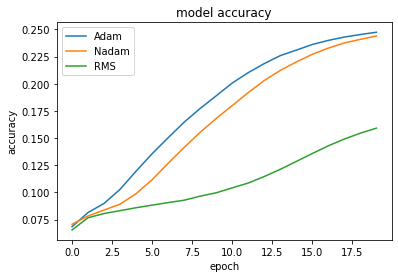

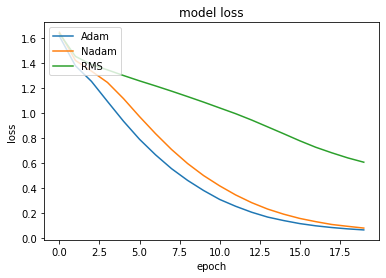

In [ ]:
plt.plot(history1_1.history['accuracy'])
plt.plot(history2_1.history['accuracy'])
plt.plot(history2_2.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Adam', 'Nadam', 'RMS'], loc='upper left')
plt.show()

plt.plot(history1_1.history['loss'])
plt.plot(history2_1.history['loss'])
plt.plot(history2_2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Adam', 'Nadam', 'RMS'], loc='upper left')
plt.show()

- Nadam은 Learning Rate Schedule을 사용할 수 없으므로 Learning Rate를 0.001로 고정합니다.  
Optimizer를 제외하고 모두 동일한 조건에서 Adam optimizer가 가장 좋은 accuracy와 loss를 기록했습니다.

#### 1.6.3 Num_Layers

- Layer 개수에 변화를 줍니다.
- 여기부터는 hyper parameter에 직접적인 변화가 있으므로 값을 수정한 후 모델을 다시 생성해야 합니다.

##### 1) High

In [ ]:
# 하이퍼파라미터
NUM_LAYERS = 4      # 인코더와 디코더의 층의 개수
D_MODEL = 256       # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8       # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512         # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.2       # 드롭아웃의 비율

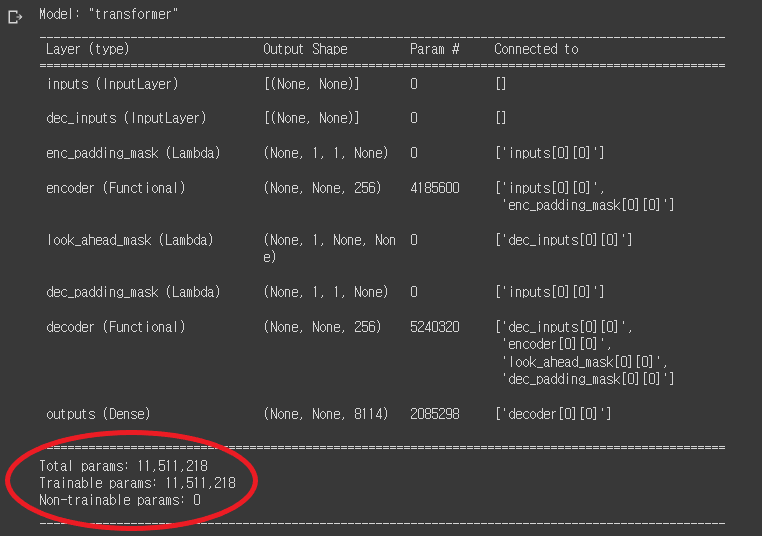

In [ ]:
insert_img_1 = '/gdrive/My Drive/Colab Notebooks/data/chat_bot/images/1.6.3_1.png'
insert_img_1 = cv2.imread(insert_img_1)
cv2_imshow(insert_img_1)

- 모델의 변화를 확인할 수 있습니다.

In [ ]:
model3_1 = model

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, max_len - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model3_1.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 20
history3_1 = model3_1.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
92/92 [==============================] - 20s 102ms/step - loss: 2.2885 - accuracy: 0.0221
Epoch 2/20
92/92 [==============================] - 10s 103ms/step - loss: 2.1041 - accuracy: 0.0370
Epoch 3/20
92/92 [==============================] - 9s 98ms/step - loss: 1.8975 - accuracy: 0.0601
Epoch 4/20
92/92 [==============================] - 9s 99ms/step - loss: 1.6857 - accuracy: 0.0748
Epoch 5/20
92/92 [==============================] - 9s 99ms/step - loss: 1.5550 - accuracy: 0.0750
Epoch 6/20
92/92 [==============================] - 9s 97ms/step - loss: 1.4726 - accuracy: 0.0770
Epoch 7/20
92/92 [==============================] - 9s 98ms/step - loss: 1.4237 - accuracy: 0.0796
Epoch 8/20
92/92 [==============================] - 9s 98ms/step - loss: 1.3845 - accuracy: 0.0819
Epoch 9/20
92/92 [==============================] - 9s 97ms/step - loss: 1.3464 - accuracy: 0.0837
Epoch 10/20
92/92 [==============================] - 9s 98ms/step - loss: 1.3101 - accuracy: 0.0850
Epoch

##### 2) Low

In [ ]:
# 하이퍼파라미터
NUM_LAYERS = 1 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.2 # 드롭아웃의 비율

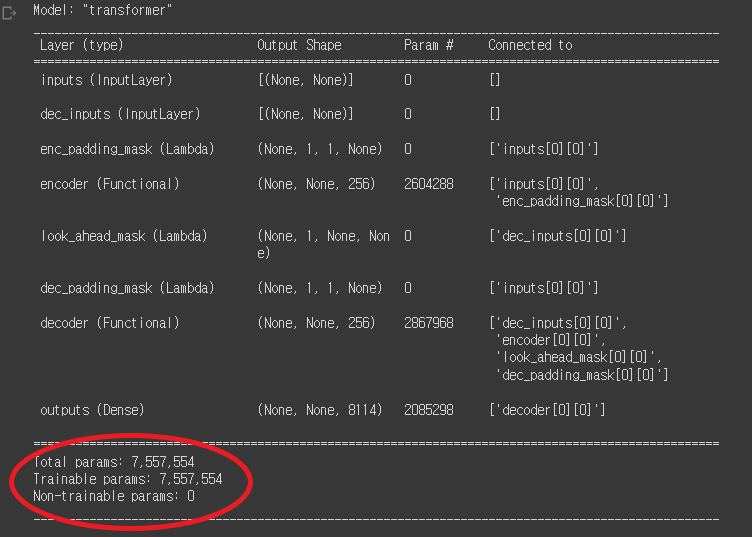

In [ ]:
insert_img_2 = '/gdrive/My Drive/Colab Notebooks/data/chat_bot/images/1.6.3_2.png'
insert_img_2 = cv2.imread(insert_img_2)
cv2_imshow(insert_img_2)

In [ ]:
model3_2 = model

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, max_len - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model3_2.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 20
history3_2 = model3_2.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
92/92 [==============================] - 8s 48ms/step - loss: 2.3268 - accuracy: 0.0167
Epoch 2/20
92/92 [==============================] - 4s 47ms/step - loss: 2.1226 - accuracy: 0.0642
Epoch 3/20
92/92 [==============================] - 4s 47ms/step - loss: 1.9036 - accuracy: 0.0739
Epoch 4/20
92/92 [==============================] - 4s 47ms/step - loss: 1.6916 - accuracy: 0.0745
Epoch 5/20
92/92 [==============================] - 4s 47ms/step - loss: 1.5522 - accuracy: 0.0752
Epoch 6/20
92/92 [==============================] - 4s 47ms/step - loss: 1.4593 - accuracy: 0.0777
Epoch 7/20
92/92 [==============================] - 4s 47ms/step - loss: 1.3970 - accuracy: 0.0811
Epoch 8/20
92/92 [==============================] - 4s 47ms/step - loss: 1.3426 - accuracy: 0.0843
Epoch 9/20
92/92 [==============================] - 4s 47ms/step - loss: 1.2906 - accuracy: 0.0874
Epoch 10/20
92/92 [==============================] - 4s 49ms/step - loss: 1.2360 - accuracy: 0.0911
Epoch 11/

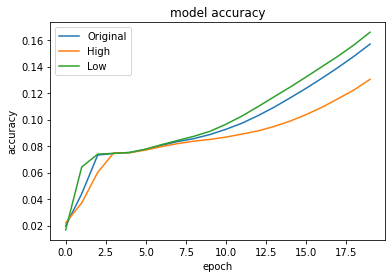

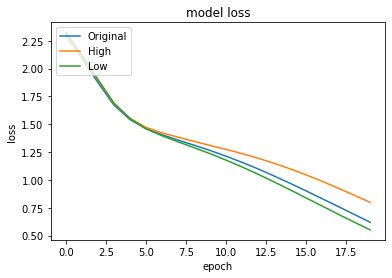

In [ ]:
plt.plot(history0_1.history['accuracy'])
plt.plot(history3_1.history['accuracy'])
plt.plot(history3_2.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Original', 'High', 'Low'], loc='upper left')
plt.show()

plt.plot(history0_1.history['loss'])
plt.plot(history3_1.history['loss'])
plt.plot(history3_2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Original', 'High', 'Low'], loc='upper left')
plt.show()

- layer 개수가 많다고 다 좋은 건 아닌 것을 확인할 수 있습니다.

#### 1.6.4 D_Model

- D_Model은 learning rate schdule에서 learning rate 값에 영향을 줍니다.
- 값을 바꾸며 확인해봅니다.

##### 1) High

In [ ]:
# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.2 # 드롭아웃의 비율

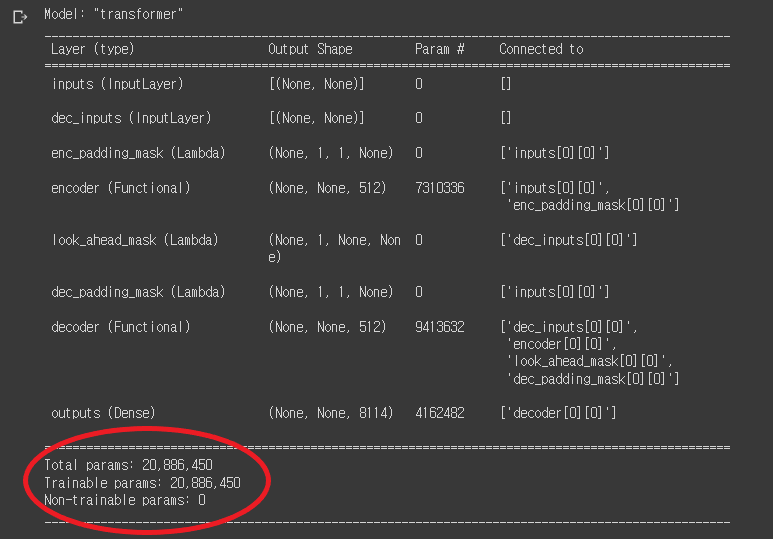

In [ ]:
insert_img_3 = '/gdrive/My Drive/Colab Notebooks/data/chat_bot/images/1.6.4_1.png'
insert_img_3 = cv2.imread(insert_img_3)
cv2_imshow(insert_img_3)

In [ ]:
model4_1 = model

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, max_len - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model4_1.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 20
history4_1 = model4_1.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
92/92 [==============================] - 15s 96ms/step - loss: 2.2223 - accuracy: 0.0257
Epoch 2/20
92/92 [==============================] - 9s 96ms/step - loss: 1.8939 - accuracy: 0.0567
Epoch 3/20
92/92 [==============================] - 9s 96ms/step - loss: 1.6549 - accuracy: 0.0742
Epoch 4/20
92/92 [==============================] - 9s 98ms/step - loss: 1.5326 - accuracy: 0.0752
Epoch 5/20
92/92 [==============================] - 9s 100ms/step - loss: 1.4641 - accuracy: 0.0782
Epoch 6/20
92/92 [==============================] - 9s 101ms/step - loss: 1.4089 - accuracy: 0.0815
Epoch 7/20
92/92 [==============================] - 9s 97ms/step - loss: 1.3548 - accuracy: 0.0843
Epoch 8/20
92/92 [==============================] - 9s 96ms/step - loss: 1.2999 - accuracy: 0.0873
Epoch 9/20
92/92 [==============================] - 9s 96ms/step - loss: 1.2422 - accuracy: 0.0908
Epoch 10/20
92/92 [==============================] - 9s 98ms/step - loss: 1.1800 - accuracy: 0.0954
Epoch 

##### 2) Low

In [ ]:
# 하이퍼파라미터
NUM_LAYERS = 2      # 인코더와 디코더의 층의 개수
D_MODEL = 128       # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8       # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512         # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.2       # 드롭아웃의 비율

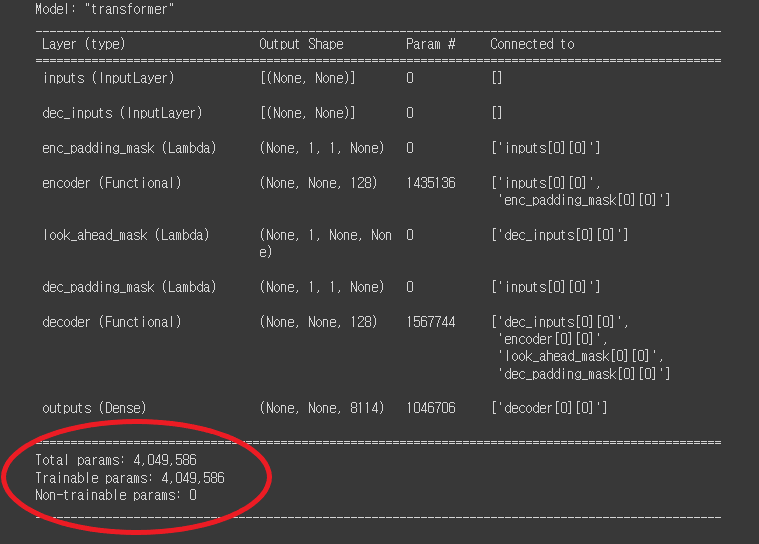

In [ ]:
insert_img_4 = '/gdrive/My Drive/Colab Notebooks/data/chat_bot/images/1.6.4_2.png'
insert_img_4 = cv2.imread(insert_img_4)
cv2_imshow(insert_img_4)

In [ ]:
model4_2 = model

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, max_len - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model4_2.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 20
history4_2 = model4_2.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
92/92 [==============================] - 11s 54ms/step - loss: 2.3192 - accuracy: 0.0202
Epoch 2/20
92/92 [==============================] - 5s 54ms/step - loss: 2.2039 - accuracy: 0.0402
Epoch 3/20
92/92 [==============================] - 5s 54ms/step - loss: 2.0489 - accuracy: 0.0638
Epoch 4/20
92/92 [==============================] - 5s 53ms/step - loss: 1.8587 - accuracy: 0.0743
Epoch 5/20
92/92 [==============================] - 5s 53ms/step - loss: 1.6919 - accuracy: 0.0749
Epoch 6/20
92/92 [==============================] - 5s 54ms/step - loss: 1.5675 - accuracy: 0.0750
Epoch 7/20
92/92 [==============================] - 5s 54ms/step - loss: 1.4695 - accuracy: 0.0763
Epoch 8/20
92/92 [==============================] - 5s 53ms/step - loss: 1.4086 - accuracy: 0.0800
Epoch 9/20
92/92 [==============================] - 5s 53ms/step - loss: 1.3628 - accuracy: 0.0831
Epoch 10/20
92/92 [==============================] - 5s 53ms/step - loss: 1.3190 - accuracy: 0.0853
Epoch 11

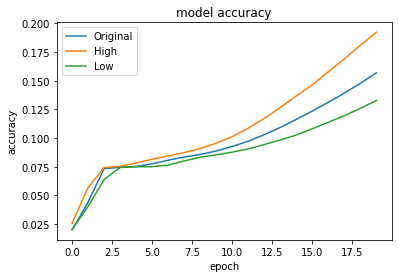

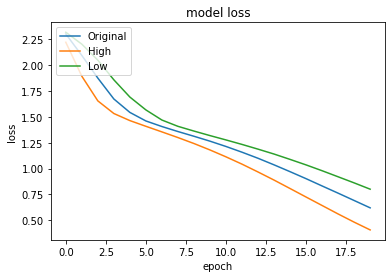

In [ ]:
plt.plot(history0_1.history['accuracy'])
plt.plot(history4_1.history['accuracy'])
plt.plot(history4_2.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Original', 'High', 'Low'], loc='upper left')
plt.show()

plt.plot(history0_1.history['loss'])
plt.plot(history4_1.history['loss'])
plt.plot(history4_2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Original', 'High', 'Low'], loc='upper left')
plt.show()

- 단순히 learning rate에만 영향을 주는 것이 아니라 encoder, decoder의 dimension에도 영향을 주는 것 같습니다.  
D_Model은 높은 값을 설정하고 learning rate를 고정하는 것이 좋겠습니다.

#### 1.6.5 Num_Head

- 처리 속도를 높이는 부분이라 제일 의미가 없을 것 같지만 확인해봅니다.  
- 참고로 multi head attention에서 d_model을 num_heads로 나누고 정수값만 취하는데 나머지가 남게끔 값을 세팅하면 error가 발생합니다. 

##### 1) High

In [ ]:
# 하이퍼파라미터
NUM_LAYERS = 2      # 인코더와 디코더의 층의 개수
D_MODEL = 256       # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 16      # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512         # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.2       # 드롭아웃의 비율

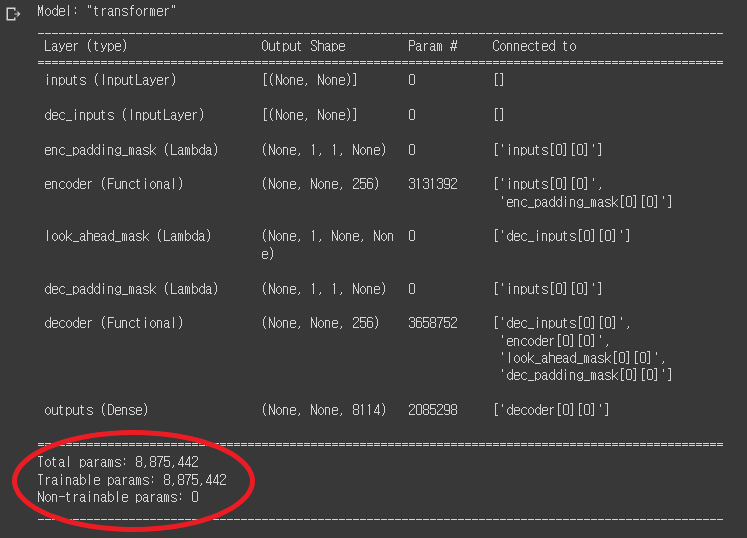

In [ ]:
insert_img_5 = '/gdrive/My Drive/Colab Notebooks/data/chat_bot/images/1.6.5_1.png'
insert_img_5 = cv2.imread(insert_img_5)
cv2_imshow(insert_img_5)

- 역시 변화가 없습니다.

In [ ]:
model5_1 = model

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, max_len - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model5_1.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 20
history5_1 = model5_1.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
92/92 [==============================] - 13s 73ms/step - loss: 2.3012 - accuracy: 0.0188
Epoch 2/20
92/92 [==============================] - 6s 69ms/step - loss: 2.0950 - accuracy: 0.0532
Epoch 3/20
92/92 [==============================] - 6s 69ms/step - loss: 1.8806 - accuracy: 0.0734
Epoch 4/20
92/92 [==============================] - 6s 70ms/step - loss: 1.6743 - accuracy: 0.0744
Epoch 5/20
92/92 [==============================] - 7s 75ms/step - loss: 1.5472 - accuracy: 0.0750
Epoch 6/20
92/92 [==============================] - 7s 71ms/step - loss: 1.4640 - accuracy: 0.0772
Epoch 7/20
92/92 [==============================] - 6s 69ms/step - loss: 1.4085 - accuracy: 0.0805
Epoch 8/20
92/92 [==============================] - 6s 69ms/step - loss: 1.3596 - accuracy: 0.0836
Epoch 9/20
92/92 [==============================] - 7s 72ms/step - loss: 1.3113 - accuracy: 0.0860
Epoch 10/20
92/92 [==============================] - 7s 74ms/step - loss: 1.2633 - accuracy: 0.0886
Epoch 11

##### 2) Low

In [ ]:
# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 4 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.2 # 드롭아웃의 비율

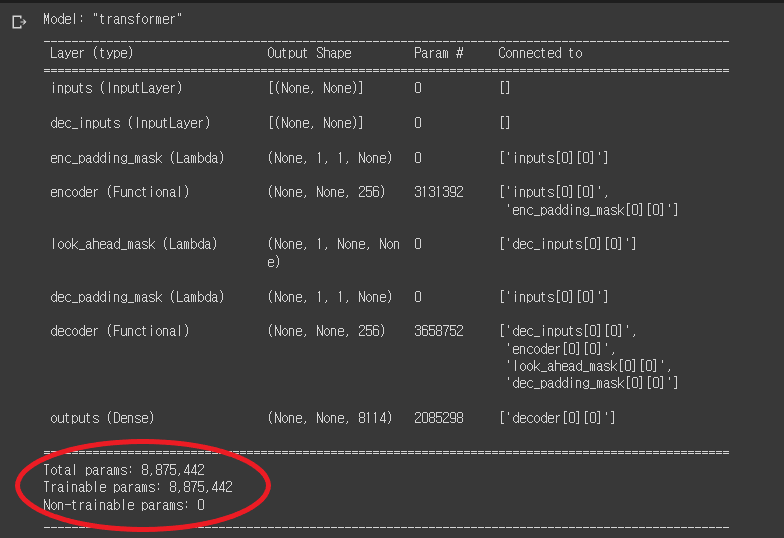

In [ ]:
insert_img_6 = '/gdrive/My Drive/Colab Notebooks/data/chat_bot/images/1.6.5_2.png'
insert_img_6 = cv2.imread(insert_img_6)
cv2_imshow(insert_img_6)

In [ ]:
model5_2 = model

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, max_len - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model5_2.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 20
history5_2 = model5_2.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
92/92 [==============================] - 12s 63ms/step - loss: 2.3044 - accuracy: 0.0212
Epoch 2/20
92/92 [==============================] - 6s 63ms/step - loss: 2.0976 - accuracy: 0.0606
Epoch 3/20
92/92 [==============================] - 6s 63ms/step - loss: 1.8759 - accuracy: 0.0740
Epoch 4/20
92/92 [==============================] - 6s 63ms/step - loss: 1.6779 - accuracy: 0.0748
Epoch 5/20
92/92 [==============================] - 6s 63ms/step - loss: 1.5482 - accuracy: 0.0751
Epoch 6/20
92/92 [==============================] - 6s 67ms/step - loss: 1.4635 - accuracy: 0.0777
Epoch 7/20
92/92 [==============================] - 6s 64ms/step - loss: 1.4085 - accuracy: 0.0807
Epoch 8/20
92/92 [==============================] - 6s 64ms/step - loss: 1.3599 - accuracy: 0.0835
Epoch 9/20
92/92 [==============================] - 6s 64ms/step - loss: 1.3125 - accuracy: 0.0858
Epoch 10/20
92/92 [==============================] - 6s 65ms/step - loss: 1.2651 - accuracy: 0.0887
Epoch 11

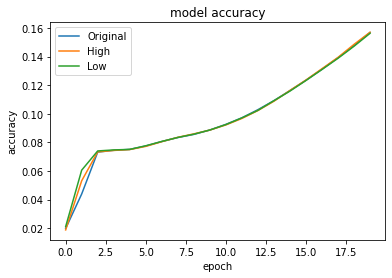

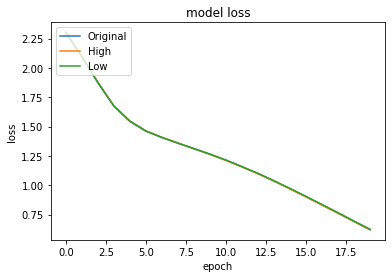

In [ ]:
plt.plot(history0_1.history['accuracy'])
plt.plot(history5_1.history['accuracy'])
plt.plot(history5_2.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Original', 'High', 'Low'], loc='upper left')
plt.show()

plt.plot(history0_1.history['loss'])
plt.plot(history5_1.history['loss'])
plt.plot(history5_2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Original', 'High', 'Low'], loc='upper left')
plt.show()

- 다음으로 넘어갑니다.

#### 1.6.6 Units

- 순방향 신경망에서의 은닉층 크기를 의미한다고 합니다.  
변화를 주며 확인해봅니다.


##### 1) High

In [ ]:
# 하이퍼파라미터
NUM_LAYERS = 2      # 인코더와 디코더의 층의 개수
D_MODEL = 256       # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8       # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 1024        # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.2       # 드롭아웃의 비율

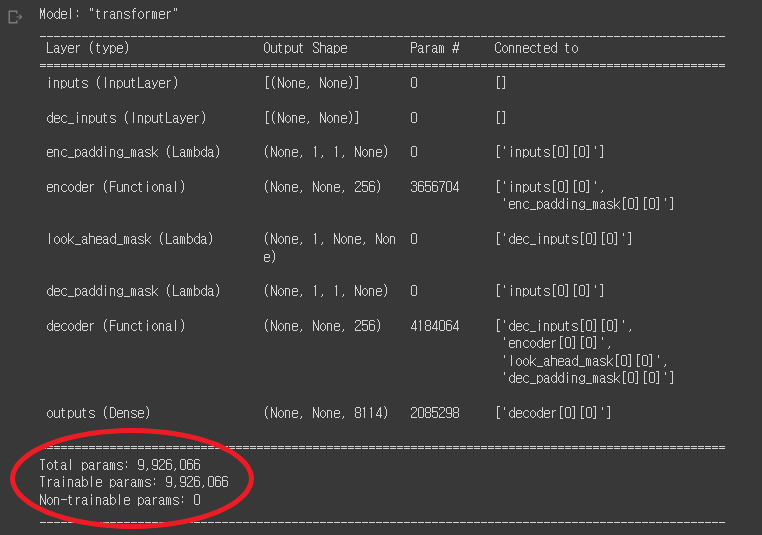

In [ ]:
insert_img_7 = '/gdrive/My Drive/Colab Notebooks/data/chat_bot/images/1.6.6_1.png'
insert_img_7 = cv2.imread(insert_img_7)
cv2_imshow(insert_img_7)

In [ ]:
model6_1 = model

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, max_len - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model6_1.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 20
history6_1 = model6_1.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
92/92 [==============================] - 13s 68ms/step - loss: 2.2876 - accuracy: 0.0227
Epoch 2/20
92/92 [==============================] - 6s 68ms/step - loss: 2.0833 - accuracy: 0.0404
Epoch 3/20
92/92 [==============================] - 6s 68ms/step - loss: 1.8686 - accuracy: 0.0721
Epoch 4/20
92/92 [==============================] - 6s 68ms/step - loss: 1.6679 - accuracy: 0.0747
Epoch 5/20
92/92 [==============================] - 6s 68ms/step - loss: 1.5424 - accuracy: 0.0752
Epoch 6/20
92/92 [==============================] - 6s 68ms/step - loss: 1.4580 - accuracy: 0.0779
Epoch 7/20
92/92 [==============================] - 6s 68ms/step - loss: 1.4000 - accuracy: 0.0814
Epoch 8/20
92/92 [==============================] - 6s 68ms/step - loss: 1.3497 - accuracy: 0.0844
Epoch 9/20
92/92 [==============================] - 6s 68ms/step - loss: 1.3009 - accuracy: 0.0870
Epoch 10/20
92/92 [==============================] - 6s 68ms/step - loss: 1.2501 - accuracy: 0.0904
Epoch 11

##### 2) Low

In [ ]:
# 하이퍼파라미터
NUM_LAYERS = 2      # 인코더와 디코더의 층의 개수
D_MODEL = 256       # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8       # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 256         # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.2       # 드롭아웃의 비율

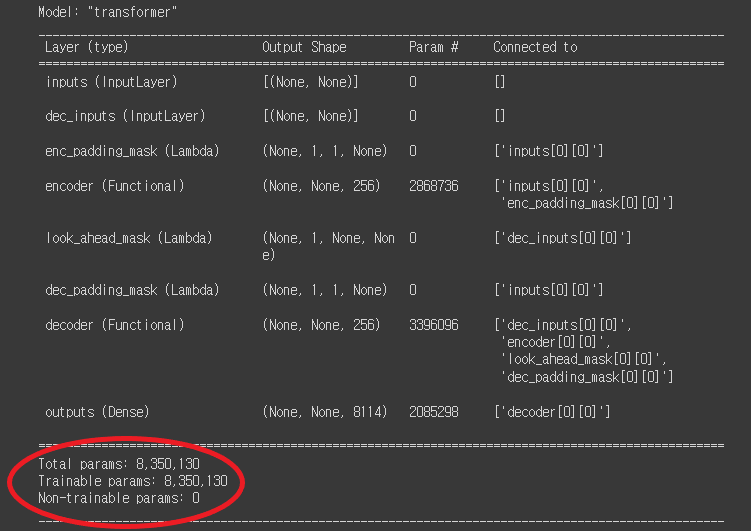

In [ ]:
insert_img_8 = '/gdrive/My Drive/Colab Notebooks/data/chat_bot/images/1.6.6_2.png'
insert_img_8 = cv2.imread(insert_img_8)
cv2_imshow(insert_img_8)

In [ ]:
model6_2 = model

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, max_len - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model6_2.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 20
history6_2 = model6_2.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
92/92 [==============================] - 12s 63ms/step - loss: 2.3101 - accuracy: 0.0167
Epoch 2/20
92/92 [==============================] - 6s 63ms/step - loss: 2.1036 - accuracy: 0.0449
Epoch 3/20
92/92 [==============================] - 6s 63ms/step - loss: 1.8981 - accuracy: 0.0673
Epoch 4/20
92/92 [==============================] - 6s 63ms/step - loss: 1.6850 - accuracy: 0.0742
Epoch 5/20
92/92 [==============================] - 6s 63ms/step - loss: 1.5596 - accuracy: 0.0749
Epoch 6/20
92/92 [==============================] - 6s 63ms/step - loss: 1.4715 - accuracy: 0.0769
Epoch 7/20
92/92 [==============================] - 6s 63ms/step - loss: 1.4112 - accuracy: 0.0804
Epoch 8/20
92/92 [==============================] - 6s 63ms/step - loss: 1.3615 - accuracy: 0.0832
Epoch 9/20
92/92 [==============================] - 6s 63ms/step - loss: 1.3135 - accuracy: 0.0856
Epoch 10/20
92/92 [==============================] - 6s 63ms/step - loss: 1.2657 - accuracy: 0.0885
Epoch 11

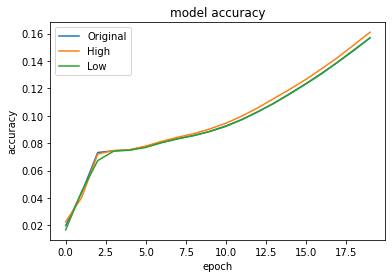

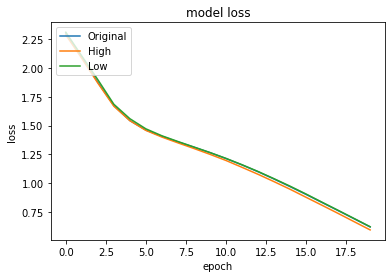

In [ ]:
plt.plot(history0_1.history['accuracy'])
plt.plot(history6_1.history['accuracy'])
plt.plot(history6_2.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Original', 'High', 'Low'], loc='upper left')
plt.show()

plt.plot(history0_1.history['loss'])
plt.plot(history6_1.history['loss'])
plt.plot(history6_2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Original', 'High', 'Low'], loc='upper left')
plt.show()

- 큰 변화는 없습니다.

### 1.7 Evaluation

- accuracy를 기준으로 제일 높은 모델과 낮은 모델을 비교해봅니다.

In [ ]:
def decoder_inference(sentence, model_name):
    sentence = re.sub(r'([?.!,])', r' \1 ', sentence)
    sentence = sentence.strip()
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
    
    output_sequence = tf.expand_dims(START_TOKEN, 0)
    
    for i in range(max_len):
        predictions = model_name(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]
        
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        
        if tf.equal(predicted_id, END_TOKEN[0]): # 종료토큰 나오면 예측 종료
            break
            
        # 다시 디코더의 입력이 된다. 
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)
        
    return tf.squeeze(output_sequence, axis=0)

In [ ]:
def sentence_generation(sentence, model_name):
    prediction = decoder_inference(sentence, model_name)
    predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])
    
    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))    
    
    return predicted_sentence

In [ ]:
sentence_generation('배고프다', model1_1)

입력 : 배고프다
출력 : 저도 밥 먹고 싶어요


'저도 밥 먹고 싶어요'

- 바람직한 답변입니다.

In [ ]:
sentence_generation('배고프다', model1_2)

입력 : 배고프다
출력 : 잘 찾아보세요 .


'잘 찾아보세요 .'

- 찾으면 음식을 줄까요?

In [ ]:
sentence_generation('여행 가고 싶다', model1_1)

입력 : 여행 가고 싶다
출력 : 편하게 쉴 수 있는 곳이 좋을 거예요 .


'편하게 쉴 수 있는 곳이 좋을 거예요 .'

- 뭐... 맞는 말만 골라합니다.

In [ ]:
sentence_generation('여행 가고 싶다', model1_2)

입력 : 여행 가고 싶다
출력 : 좋은 사람 만날 수 있을 거예요 .


'좋은 사람 만날 수 있을 거예요 .'

- 뜬금 없는 위로입니다.  
약을 올리네요.  
그만 알아봅니다.

## 2. Pororo

- Pororo는 카카오 브레인에서 제공하는 자연어 처리 플랫폼으로 감정 분석 같은 분류도 가능하고 품사 태깅, 기계 번역, 텍스트 요약, 음성 인식 등이 가능합니다. 게다가 중국어, 일본어, 영어도 사용할 수 있습니다.
- 사용법이 간단한게 가장 매력적입니다.
- 다만 설치가 조금 복잡합니다. !pip install pororo는 설치 도중에 멈추므로 git에서 직접 clone으로 가져와 설치해야 합니다.
- 카카오브레인 Pororo : https://kakaobrain.github.io/pororo/

### 2.1 Module

In [1]:
!pip install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 6.9 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3


In [2]:
!git clone https://github.com/kakaobrain/pororo.git

Cloning into 'pororo'...
remote: Enumerating objects: 2119, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 2119 (delta 11), reused 22 (delta 8), pack-reused 2090
Receiving objects: 100% (2119/2119), 13.09 MiB | 9.08 MiB/s, done.
Resolving deltas: 100% (1448/1448), done.


In [3]:
ls

pororo/  sample_data/


In [4]:
cd pororo

/content/pororo


In [5]:
!pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/pororo
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 748.8/748.8 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 28.7 MB/s eta 0:00:00
  Preparing metadata (set

In [1]:
!pwd

/content


- 설치가 번거롭습니다.

In [3]:
from pororo import Pororo
import pandas as pd
from sentence_transformers import util
from tqdm import tqdm
import torch
import numpy as np

from google.colab import drive
from google.colab.patches import cv2_imshow

In [4]:
tqdm.pandas()

- Pororo 패키지를 확인해봅니다.

In [25]:
dir(Pororo)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'available_models',
 'available_tasks']

- 가능한 task를 확인할 수 있습니다.

In [26]:
Pororo.available_tasks()

"Available tasks are ['mrc', 'rc', 'qa', 'question_answering', 'machine_reading_comprehension', 'reading_comprehension', 'sentiment', 'sentiment_analysis', 'nli', 'natural_language_inference', 'inference', 'fill', 'fill_in_blank', 'fib', 'para', 'pi', 'cse', 'contextual_subword_embedding', 'similarity', 'sts', 'semantic_textual_similarity', 'sentence_similarity', 'sentvec', 'sentence_embedding', 'sentence_vector', 'se', 'inflection', 'morphological_inflection', 'g2p', 'grapheme_to_phoneme', 'grapheme_to_phoneme_conversion', 'w2v', 'wordvec', 'word2vec', 'word_vector', 'word_embedding', 'tokenize', 'tokenise', 'tokenization', 'tokenisation', 'tok', 'segmentation', 'seg', 'mt', 'machine_translation', 'translation', 'pos', 'tag', 'pos_tagging', 'tagging', 'const', 'constituency', 'constituency_parsing', 'cp', 'pg', 'collocation', 'collocate', 'col', 'word_translation', 'wt', 'summarization', 'summarisation', 'text_summarization', 'text_summarisation', 'summary', 'gec', 'review', 'review_s

- 눈에 들어오는 게 많습니다. ocr이라던지...

### 2.2 Function

#### 2.2.1 return_question

- 문장을 넣으면 pororo의 sentence_embedding을 통해 tensor로 바꿔주는 과정까지 수행합니다.

In [27]:
def return_question(input_sentence):
  input_sentence = ev(input_sentence)
  input_sentence = torch.tensor(input_sentence)
  return input_sentence

#### 2.2.2 pororo

- tensor로 받으면 받은 tensor의 유사도와 가장 비슷한 질문을 찾아 해당 답변을 반환합니다.

In [28]:
def pororo(message):
  message = message.strip()
  embedding_sentence = return_question(message)
  
  cos_sim = util.pytorch_cos_sim(embedding_sentence,embedding_data)
  cos_sim = cos_sim.cpu()
  
  best_sim_idx = int(np.argmax(cos_sim))

  answer = data['A'][best_sim_idx]
  return answer

### 2.3 Data

- data를 다시 불러옵니다.
- 한국어 챗봇 데이터는 https://github.com/songys/Chatbot_data 송영숙님 데이터를 사용합니다. 

In [5]:
drive.mount('/gdrive')

Mounted at /gdrive


In [9]:
data = pd.read_csv('/gdrive/My Drive/Colab Notebooks/data/chat_bot/ChatbotData.csv')

- Q 칼럼에 대해 embedding vactor 값을 구해 embedding_vectors 컬럼을 생성해 넣어주는 과정입니다.

- pororo의 sentence_embedding task를 사용합니다.
- 질문 Q 컬럼의 embedding vector 값을 구합니다.

In [10]:
ev = Pororo(task="sentence_embedding", lang="ko")
data['embedding_vectors'] = data['Q'].progress_map(lambda x : ev(x))




100%|██████████| 11823/11823 [03:34<00:00, 55.06it/s]


- 약 3~4분 정도 소요됩니다.

In [12]:
data.tail(3)

,Q,A,label,embedding_vectors
11820,흑기사 해주는 짝남.,설렜겠어요.,2,"[0.24632202, -0.14750546, -0.20554727, 0.15494..."
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2,"[0.038064502, 0.09840195, -0.28763157, 0.06281..."
11822,힘들어서 결혼할까봐,도피성 결혼은 하지 않길 바라요.,2,"[-0.095139176, 0.13484907, 0.19429329, 0.06101..."


- 잘 나옵니다. 넘어갑니다.

- pororo 함수의 cosin 유사도를 구하기 위해 embedding_vectors를 tensor로 바꿔줍니다.  
cos_sim = util.pytorch_cos_sim(embedding_sentence,embedding_data)

In [13]:
embedding_data = torch.tensor(data['embedding_vectors'].tolist())

- 준비는 끝났으니 확인해봅니다.

In [20]:
pororo("커피가 마시고 싶어")

'카페인이 필요한 시간인가 봐요.'

In [21]:
pororo("배고프다")

'저도 밥 먹고 싶어요'

In [23]:
pororo("여행 가고 싶다")

'계획을 세워보세요.'

- 아주 깔끔한 답변을 해줍니다.   
물론 input data의 한계가 있어 정형화된 질문에 정형화된 답변이겠지만, data가 더 많으면 의미있는 챗봇이 만들어질 것 같습니다.

## 2. Retrospect

##### 1) Hyper Parameter
- 하이퍼 파라미터의 차이가 생각보다 큽니다.  
특히 적절한 learning rate와 layer, optimizer를 정하는 것이 중요하다고 생각합니다.  
그리고 하이퍼 파라미터의 변화에 따른 결과의 변화를 보는 것이 재미있습니다.

##### 2) Data
- 더 많은 대화형 데이터를 넣어보고 싶습니다.  
11,800개 데이터로는 너무 적다는 느낌을 받았습니다.  
심심이 같은 매운맛을 원했는데 이번 데이터는 순한맛이라 조금 아쉬운 부분도 있습니다.

##### 3) Study
- Attention, Transformer에 대해 대략적인 이해를 할 수 있었으나 더 세부적으로 살펴보고 싶습니다. 공부할게 더 쌓여갑니다.  
https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf

##### 4) Pororo
- 단 몇줄로 그 많은 작업을 편리하게 수행해줍니다만, 설치가 좀 복잡한 편입니다.  
그냥 !pip install pororo로는 코랩에서는 설치가 불가했습니다.  
설치 말고는 나머지는 너무 편리해서 좋습니다. 날로먹은 느낌입니다.

##### 5) koGPT
- 21년 11월에 나온 GPT-3를 기반으로 하는 koGPT를 써보고 싶었습니다만, 크기만 11.5기가입니다.  
- 다음에 시간이 많으면 시도해보려 합니다.
- https://github.com/kakaobrain/kogpt

## 3. References

- 아래의 사이트에서 큰 도움을 받았습니다.

##### 1) Chat bot data
- https://github.com/songys/Chatbot_data

##### 2) Attention
- https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf

##### 3) Learning rate schedule
- https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/LearningRateSchedule

##### 4) Feed Forward Neural
- https://wikidocs.net/24987

##### 5) Pororo
-  https://kakaobrain.github.io/pororo/

##### 6) koGPT
 - https://github.com/kakaobrain/kogpt

##### 7) Dataset
- https://www.tensorflow.org/api_docs/python/tf/data/Dataset
- https://helloyjam.github.io/tensorflow/buffer-size-in-shuffle/

##### 8) Transpose
- https://www.tensorflow.org/api_docs/python/tf/transpose#args